In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import ast

%load_ext google.cloud.bigquery

# Data Load

In [2]:
%%bigquery df

WITH clean AS 
(
SELECT 
  DISTINCT full_visitor_id , client_id , organization_uuid , country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created , 
  traffic_source_level_3 , traffic_source_source, traffic_source_medium,
  COUNT(DISTINCT organization_uuid) OVER(PARTITION BY full_visitor_id ) as nr_unique_uuid
FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
WHERE full_visitor_id NOT IN (--list of visitor id that has no client id and only one unique (NA) uuid and 
                          SELECT
                              full_visitor_id 
                          FROM (
                                SELECT
                                    DISTINCT full_visitor_id , client_id , organization_uuid  ,
                                    DENSE_RANK() OVER(PARTITION BY full_visitor_id ORDER BY client_id DESC, organization_uuid DESC) as rank_entry 
                                    #optimize the code by group by and array_agg()?
                                FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
                                WHERE full_visitor_id IN (SELECT 
                                                            DISTINCT full_visitor_id
                                                          FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
                                                          WHERE client_id IS NULL AND organization_uuid IS NULL
                                                          )
                                #ORDER BY full_visitor_id , rank_entry
                                      )
                          WHERE rank_entry = 1
                          AND client_id IS NULL
                          AND organization_uuid IS NULL
                          ) 
), 
ga_processed AS (
--delete row with no uuid and nr_unique_uuid per group of visitor id of that row > 1 
-- and fill NA uuid cells (Expected: rows with NA uuid and nr_unique_uuid =0 left)--
SELECT 
  full_visitor_id , client_id , organization_uuid , 
  IFNULL(organization_uuid, MAX(organization_uuid) OVER(PARTITION BY full_visitor_id)) as fill_uuid ,
  country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created ,
  traffic_source_level_3 , traffic_source_source, traffic_source_medium,
  nr_unique_uuid
FROM clean
WHERE 
  organization_uuid IS NOT NULL
  #OR
  #(organization_uuid IS NULL  
  #AND nr_unique_uuid = 0 AND client_id IS NOT NULL) 
  OR
  (organization_uuid IS NULL AND nr_unique_uuid <= 1)
),
merged_campaign AS(
SELECT
  full_visitor_id , 
  IFNULL(fill_uuid, MAX(campaign_data.organization_uuid) OVER(PARTITION BY client_id)) as fill_uuid_2,
  country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created ,
  traffic_source_level_3, traffic_source_source, traffic_source_medium
FROM ga_processed
LEFT JOIN (SELECT
              DISTINCT google_analytics_id , organization_uuid 
           FROM `izettle-dp-pipeline-prod.legacy_views.user_campaign_data`
           WHERE google_analytics_id IN (
                                         SELECT DISTINCT google_analytics_id
                                         FROM `izettle-dp-pipeline-prod.legacy_views.user_campaign_data`
                                         GROUP BY google_analytics_id 
                                         HAVING COUNT(DISTINCT organization_uuid) = 1
                                         ) 
          ) AS campaign_data
ON ga_processed.client_id = campaign_data.google_analytics_id 
),
merged_oc AS (
--customer journey of merchants until registration tracked by ga cookies--
--only ~ 245,000 merchants have the recorded journey. The rest that we have only the last touch point can be found in the customer_acquisition table--
SELECT
  ft.fill_uuid_2 as organization_uuid , oc.organization_created ,
  ft.full_visitor_id, ft.country_id , ft.session_id , ft.session_start_time , ft.session_end_time ,
  ft.session_reached_minimal_created ,
  ft.traffic_source_level_3,
  traffic_source_source, traffic_source_medium
FROM merged_campaign ft
LEFT JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
ON ft.fill_uuid_2 =oc.organization_uuid 
WHERE fill_uuid_2 IS NOT NULL
AND oc.organization_created >= ft.session_start_time 
)
SELECT
  uuid_left.organization_uuid ,
  uuid_left.organization_created ,
  #uuid_left.traffic_source_level_3 as traffic_source_level_3_af ,
  #merged_oc.full_visitor_id, 
  uuid_left.country_id , 
  merged_oc.session_id , merged_oc.session_start_time , merged_oc.session_end_time ,
  merged_oc.session_reached_minimal_created ,
  #merged_oc.traffic_source_level_3,
  #merged_oc.traffic_source_source, merged_oc.traffic_source_medium,
  IFNULL(merged_oc.traffic_source_level_3, uuid_left.traffic_source_level_3) as traffic_source_full
FROM (
      SELECT 
        af.organization_uuid, oc.country_id,
        af.traffic_source_level_3 , oc.organization_created 
      FROM `izettle-dp-pipeline-prod.legacy_views.attribution_funnel_traffic_source` af
      JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
      ON af.organization_uuid = oc.organization_uuid 
      AND oc.organization_created >= '2017-09-01'
      ) as uuid_left
LEFT JOIN merged_oc
ON uuid_left.organization_uuid = merged_oc.organization_uuid 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736765 entries, 0 to 1736764
Data columns (total 8 columns):
organization_uuid                  object
organization_created               datetime64[ns, UTC]
country_id                         object
session_id                         object
session_start_time                 object
session_end_time                   object
session_reached_minimal_created    object
traffic_source_full                object
dtypes: datetime64[ns, UTC](1), object(7)
memory usage: 106.0+ MB


In [4]:
%%bigquery df_af
SELECT 
  af.organization_uuid,
  oc.organization_created,
  oc.country_id,
  af.traffic_source_level_3 as traffic_source_full
FROM `izettle-dp-pipeline-prod.legacy_views.attribution_funnel_traffic_source` af
JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
ON oc.organization_uuid = af.organization_uuid
WHERE oc.organization_created >= '2017-09-01'  

In [5]:
df_af.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136918 entries, 0 to 1136917
Data columns (total 4 columns):
organization_uuid       1136918 non-null object
organization_created    1136918 non-null datetime64[ns, UTC]
country_id              1136918 non-null object
traffic_source_full     1136918 non-null object
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 34.7+ MB


In [109]:
%%bigquery df_kyc_accepted
SELECT 
  organization_uuid , country_id
FROM `izettle-dp-pipeline-prod.legacy_views.organization_customer` 
WHERE organization_created >= '2017-09-01'
AND first_non_minimal_signup_status_assigned IS NOT NULL

In [110]:
df_kyc_accepted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652769 entries, 0 to 652768
Data columns (total 2 columns):
organization_uuid    652769 non-null object
country_id           652769 non-null object
dtypes: object(2)
memory usage: 10.0+ MB


# Data Preparation

In [8]:
last_touch_ga = list(df[df['session_reached_minimal_created'] == True]['organization_uuid'].unique())
last_touch_ls = last_touch_ga + list(df[df['session_reached_minimal_created'].isna()]['organization_uuid'].unique())

In [9]:
df_concat_1 = df_af[~df_af['organization_uuid'].isin(last_touch_ls)]

In [10]:
df_concat_1['session_start_time'] = ''
df_concat_1['session_end_time'] = ''

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
df_1 = df[['organization_uuid','organization_created','country_id','traffic_source_full','session_start_time','session_end_time']]

In [12]:
df_concat_2 = df_1[df_1['session_start_time'].isna()]

In [13]:
df_concat_2['session_start_time'] = ''
df_concat_2['session_end_time'] = ''

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
df_concat_3 = df_1[~df_1['session_start_time'].isna()]

In [15]:
print(df_concat_1.info())
print(df_concat_2.info())
print(df_concat_3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40068 entries, 9 to 1136850
Data columns (total 6 columns):
organization_uuid       40068 non-null object
organization_created    40068 non-null datetime64[ns, UTC]
country_id              40068 non-null object
traffic_source_full     40068 non-null object
session_start_time      40068 non-null object
session_end_time        40068 non-null object
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 2.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 432660 entries, 0 to 432659
Data columns (total 6 columns):
organization_uuid       432660 non-null object
organization_created    432660 non-null datetime64[ns, UTC]
country_id              432660 non-null object
traffic_source_full     432660 non-null object
session_start_time      432660 non-null object
session_end_time        432660 non-null object
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 23.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1304105

In [16]:
basetable = pd.concat([df_concat_1, df_concat_2, df_concat_3], axis = 0, ignore_index=True)

In [17]:
basetable.tail()

,organization_uuid,organization_created,country_id,traffic_source_full,session_start_time,session_end_time
1776828,cd1fa1fe-0aaa-11e9-88cb-3d6ec5378b0e,2018-12-28 14:13:51.363000+00:00,NL,ps_other_local_partnership,2018-12-28 14:10:40+00:00,2018-12-28 14:14:12+00:00
1776829,04ff0d0c-4706-11e9-9645-ddcc9a5ffd95,2019-03-15 09:37:59.071000+00:00,GB,ps_other_local_partnership,2019-03-15 09:37:47+00:00,2019-03-15 09:38:38+00:00
1776830,ad73a2e6-ccde-11e9-8ef3-de408c8a0ba3,2019-09-01 17:33:57.635000+00:00,MX,ps_other_local_partnership,2019-09-01 17:33:13+00:00,2019-09-01 17:37:36+00:00
1776831,6349a1ee-86f1-11e9-897f-e2f12b826e70,2019-06-04 17:51:32.252000+00:00,GB,ps_other_local_partnership,2019-06-04 17:39:52+00:00,2019-06-04 18:57:46+00:00
1776832,41a3a540-65e5-11e8-85c2-0c224e70f73c,2018-06-01 21:46:35.796000+00:00,MX,ps_other_local_partnership,2018-06-01 21:46:34+00:00,2018-06-01 21:59:43+00:00


In [18]:
basetable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776833 entries, 0 to 1776832
Data columns (total 6 columns):
organization_uuid       object
organization_created    datetime64[ns, UTC]
country_id              object
traffic_source_full     object
session_start_time      object
session_end_time        object
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 81.3+ MB


In [19]:
basetable = basetable.assign(session_start_time = pd.to_datetime(basetable['session_start_time'], errors='coerce', utc=True),
                               session_end_time = pd.to_datetime(basetable['session_end_time'], errors='coerce',utc=True))

# Data Exploration

## Journey time

In [20]:
basetable_time = pd.DataFrame(basetable.
                              groupby(['organization_uuid','organization_created'])['session_start_time'].
                              min()).reset_index()

In [21]:
basetable_time[basetable_time['session_start_time'].isna()].shape

(432660, 3)

In [22]:
basetable_time['journey_time'] = basetable_time['organization_created'] - basetable_time['session_start_time']

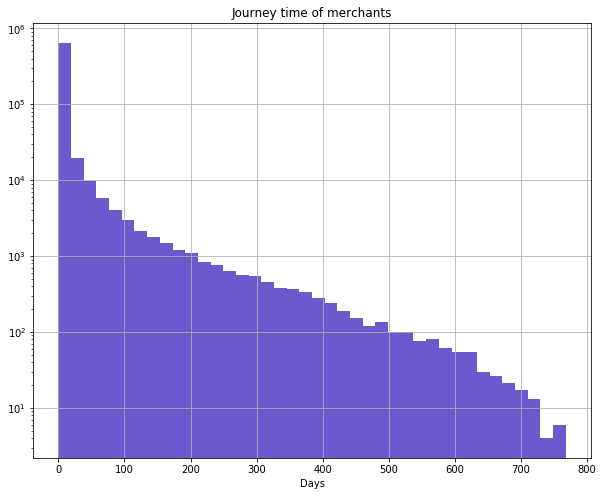

In [23]:
basetable_time['journey_time'].dt.days.hist(color = 'slateblue',
                                           bins = 40,
                                           figsize = (10,8),
                                           log = True)
plt.xlabel('Days')
plt.title('Journey time of merchants')
plt.show()

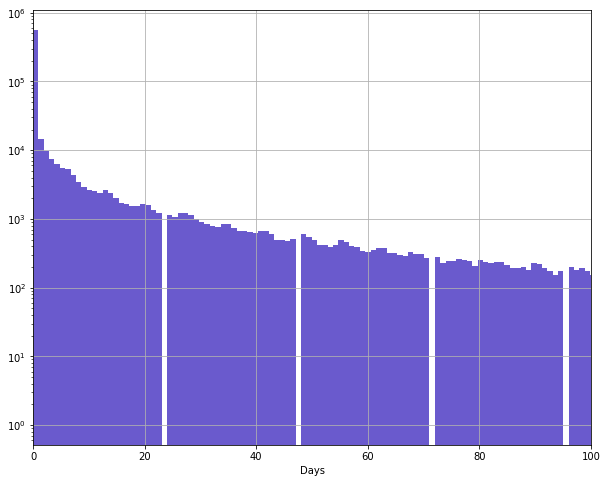

In [24]:
basetable_time['journey_time'].dt.days.hist(color = 'slateblue',
                                           bins = 800,
                                           figsize = (10,8),
                                           log = True)
plt.xlabel('Days')
plt.xlim(0,100)
plt.show()

- ~50% of merchants register during the day they searched. 

- ~60% of merchants register within 3 months of their search (11% >= 1 days)

- The rest: 38% of merchants we dont know their journey. Only know the last touch.

In [25]:
basetable_time[basetable_time['journey_time'].dt.days == 0].shape[0]

567263

In [27]:
basetable_time[basetable_time['journey_time'].dt.days >= 1].shape[0]

136995

In [28]:
print(556459/basetable_time.shape[0])
print(136995/basetable_time.shape[0])

0.4894451490784736
0.12049681683287625


## Journey touchpoints

### Nr sessions per journey: All merchants

In [29]:
nr_sessions = pd.DataFrame(basetable.groupby('organization_uuid')['organization_uuid'].count())

In [30]:
nr_sessions.rename(columns={'organization_uuid':'nr_sessions'},inplace=True)
nr_sessions.sort_values('nr_sessions')

,nr_sessions
organization_uuid,
7fd85d00-93e5-11e8-9de1-d9605ac2973a,1
9f524c70-f373-11e8-8c93-8dd7f7ce7b28,1
9f5253c0-8111-11e8-88fd-b2fe88ff68b4,1
9f527420-a49a-11e8-a4d8-bf43eb4e8124,1
9f527800-9e4a-11e7-83b8-c34610a653d6,1
...,...
5b92e210-83a7-11e8-b97e-67561a58be5b,165
b17ed82c-ee78-11e9-ba52-797b7085c73f,168
acb46f80-2d06-11e8-b345-26cafa5be1d8,176


In [31]:
print('nr_session = 1: '+ str(nr_sessions[nr_sessions['nr_sessions'] == 1].shape[0]*100/nr_sessions.shape[0]) + '%')
print('nr_session <= 4: '+ str(nr_sessions[nr_sessions['nr_sessions'] <= 4].shape[0]*100/nr_sessions.shape[0]) + '%')
print('nr_session <= 40: '+ str(nr_sessions[nr_sessions['nr_sessions'] <= 40].shape[0]*100/nr_sessions.shape[0]) + '%')

nr_session = 1: 76.98022196851488%
nr_session <= 4: 95.86856747804151%
nr_session <= 40: 99.98803783562226%


*Remarks:* 

50% of merchants that we can now trace only the last touch point in the total of number merchants that have only one session before REG.

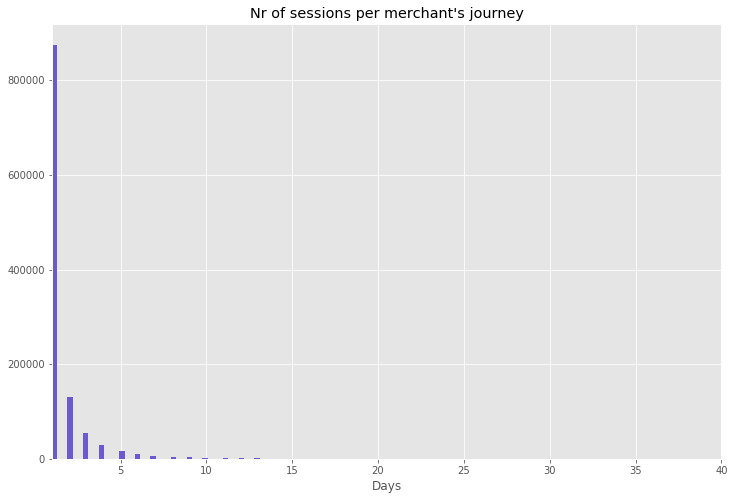

In [34]:
plt.style.use('ggplot')
nr_sessions['nr_sessions'].hist(color = 'slateblue',
                               figsize = (12,8),
                               bins = 5000)
plt.xlabel('Days')
plt.xlim(1,40)
plt.title("Nr of sessions per merchant's journey")
plt.show()

### One example: merchant with longest nr of sessions before REG

In [35]:
basetable[basetable['organization_uuid'] == 'ed14f4e0-be43-11e8-ab0d-90badb012897'].sort_values('session_start_time')

,organization_uuid,organization_created,country_id,traffic_source_full,session_start_time,session_end_time
1052905,ed14f4e0-be43-11e8-ab0d-90badb012897,2018-09-22 08:45:58.446000+00:00,NL,o_paid_sem,2018-04-09 12:10:11+00:00,2018-04-09 12:10:24+00:00
1051736,ed14f4e0-be43-11e8-ab0d-90badb012897,2018-09-22 08:45:58.446000+00:00,NL,o_paid_sem,2018-04-09 12:11:24+00:00,2018-04-09 12:11:24+00:00
1052424,ed14f4e0-be43-11e8-ab0d-90badb012897,2018-09-22 08:45:58.446000+00:00,NL,o_paid_sem,2018-04-09 12:12:39+00:00,2018-04-09 12:12:39+00:00
1051595,ed14f4e0-be43-11e8-ab0d-90badb012897,2018-09-22 08:45:58.446000+00:00,NL,o_paid_sem,2018-04-09 12:13:20+00:00,2018-04-09 12:13:20+00:00
1052269,ed14f4e0-be43-11e8-ab0d-90badb012897,2018-09-22 08:45:58.446000+00:00,NL,o_paid_sem,2018-04-09 12:14:19+00:00,2018-04-09 12:14:19+00:00
...,...,...,...,...,...,...
1052381,ed14f4e0-be43-11e8-ab0d-90badb012897,2018-09-22 08:45:58.446000+00:00,NL,o_paid_sem,2018-09-22 08:41:57+00:00,2018-09-22 08:41:58+00:00
1052081,ed14f4e0-be43-11e8-ab0d-90badb012897,2018-09-22 08:45:58.446000+00:00,NL,o_paid_sem,2018-09-22 08:42:24+00:00,2018-09-22 08:42:26+00:00
1052550,ed14f4e0-be43-11e8-ab0d-90badb012897,2018-09-22 08:45:58.446000+00:00,NL,o_paid_sem,2018-09-22 08:42:53+00:00,2018-09-22 08:42:54+00:00
1052937,ed14f4e0-be43-11e8-ab0d-90badb012897,2018-09-22 08:45:58.446000+00:00,NL,o_paid_sem,2018-09-22 08:43:25+00:00,2018-09-22 08:43:44+00:00


In [36]:
basetable[(basetable['organization_uuid'] == 'ed14f4e0-be43-11e8-ab0d-90badb012897') &
         (basetable['traffic_source_full'] != 'o_paid_sem')]

,organization_uuid,organization_created,country_id,traffic_source_full,session_start_time,session_end_time
1051894,ed14f4e0-be43-11e8-ab0d-90badb012897,2018-09-22 08:45:58.446000+00:00,NL,o_paid_social,2018-04-19 19:33:27+00:00,2018-04-19 19:33:27+00:00


**Recommendation: set up a tracking to differentiate someone accidentally click.
So record the real time of a customer on a websire regardless of their interaction.**

Internal IP?

### Nr sessions per journey: KYC accepted

In [95]:
nr_sessions_kyc = nr_sessions[nr_sessions.index.isin(df_kyc_accepted['organization_uuid'])]

In [96]:
print('nr_session = 1: '+ str(nr_sessions_ga[nr_sessions_kyc['nr_sessions'] == 1].shape[0]*100/nr_sessions_kyc.shape[0]) + '%')
print('nr_session <= 4: '+ str(nr_sessions_ga[nr_sessions_kyc['nr_sessions'] <= 4].shape[0]*100/nr_sessions_kyc.shape[0]) + '%')
print('nr_session <= 40: '+ str(nr_sessions_ga[nr_sessions_kyc['nr_sessions'] <= 40].shape[0]*100/nr_sessions_kyc.shape[0]) + '%')

nr_session = 1: 68.44412035498009%
nr_session <= 4: 93.74143073583457%
nr_session <= 40: 99.98314870957414%


In [97]:
nr_sessions_kyc.shape

(652769, 1)

### Journey's unique touchpoints

#### Only merchants with GA data

In [37]:
basetable['rank'] = basetable.groupby('organization_uuid')['session_start_time'].rank(na_option = 'bottom', ascending=False)

In [42]:
list(basetable.traffic_source_full.unique())

['ds_inbound_inbound',
 'ds_keyaccount_keyaccount',
 'o_paid_sem',
 'ps_bank_bank',
 'o_organic_app',
 'o_organic_seo',
 'o_organic_null',
 'o_organic_direct',
 'o_organic_invite',
 'o_paid_affiliate',
 'o_organic_referral',
 'ps_other_isc',
 'ps_other_partner',
 'o_paid_social',
 'o_paid_app_install',
 'pp_paypal_paypal',
 'ps_pay_sdk',
 'ps_other_local_partnership',
 'ps_product_api',
 'ds_keyaccount_sdk']

In [44]:
dict_channels = {'ps_pay_sdk':'partnerships', 'ps_product_api':'partnerships', 'ps_bank_bank':'partnerships',
                'ps_other_local_partnership':'partnerships', 'ps_other_partner':'partnerships',
                 'ps_other_isc':'partnerships', 'pp_paypal_paypal':'partnerships',
                'ds_inbound_inbound':'direct','ds_keyaccount_sdk':'direct','ds_keyaccount_keyaccount':'direct'}

def map_value(df):
    df['traffic_source'] = ''
    for i in range(0, df.shape[0]):
        if df.traffic_source_full.iloc[i] in list(dict_channels.keys()):
            df['traffic_source'].iat[i] = dict_channels[df.traffic_source_full.iloc[i]]
        else: df['traffic_source'].iat[i] = df['traffic_source_full'].iat[i]

In [45]:
map_value(basetable)

In [107]:
basetable.groupby('traffic_source')['organization_uuid'].count()

traffic_source
direct                 30185
o_organic_app         110167
o_organic_direct      212376
o_organic_invite       17620
o_organic_null        177015
o_organic_referral     38519
o_organic_seo         237150
o_paid_affiliate      110250
o_paid_app_install     15746
o_paid_sem            661711
o_paid_social          86198
partnerships           79896
Name: organization_uuid, dtype: int64

In [46]:
basetable_ga = basetable[~((basetable['session_end_time'].isna()) & (basetable['rank'] == 1))][['organization_uuid',
                                                                                               'organization_created',
                                                                                                'country_id',
                                                                                               'traffic_source']]

In [47]:
basetable_ga.head()

,organization_uuid,organization_created,country_id,traffic_source
0,d3ac0460-1b11-11e8-b465-7beaf8399d76,2018-02-26 16:26:41.446000+00:00,IT,direct
1,ce4da810-0c21-11e8-b84e-c11e2b7835df,2018-02-07 16:13:16.946000+00:00,IT,direct
2,940f6300-09bf-11e8-970c-b9a7287d10cd,2018-02-04 15:25:06.224000+00:00,IT,direct
3,720511c0-b577-11e7-b192-f5594d09f104,2017-10-20 09:17:07.676000+00:00,IT,direct
4,73055680-1629-11e8-a732-832622cb0e44,2018-02-20 10:33:11.400000+00:00,IT,direct


In [50]:
%%time
journey_ga = pd.DataFrame(basetable_ga.groupby('organization_uuid')['traffic_source'].apply(list))

CPU times: user 46.8 s, sys: 62.2 ms, total: 46.8 s
Wall time: 46.8 s


In [52]:
journey_ga.info()

<class 'pandas.core.frame.DataFrame'>
Index: 704258 entries, 00000d7a-905c-11e9-9233-ae9d68e66093 to ffffe67a-9c8a-11e9-a9f1-9fc0bb8c673d
Data columns (total 1 columns):
traffic_source    704258 non-null object
dtypes: object(1)
memory usage: 10.7+ MB


In [72]:
journey_ga['traffic_source_unique'] = [sorted(list(set(i))) for i in journey_ga['traffic_source']]
                                                

In [75]:
journey_ga.head()

,traffic_source,traffic_source_unique
organization_uuid,,
00000d7a-905c-11e9-9233-ae9d68e66093,"[o_paid_sem, o_paid_sem, o_paid_sem, o_paid_se...",[o_paid_sem]
00001110-992a-11e7-9808-8ab8ae4b9c97,"[o_paid_sem, o_organic_seo]","[o_organic_seo, o_paid_sem]"
000025a0-4885-11e8-b4f3-557d531c63b3,"[o_paid_sem, o_paid_sem]",[o_paid_sem]
00002cb0-9c8e-11e7-bf87-b0512ff760df,[o_organic_direct],[o_organic_direct]
00003340-368a-11e8-812c-46c00ef89793,[o_organic_direct],[o_organic_direct]


In [77]:
journey_ga_nr = pd.DataFrame(journey_ga['traffic_source_unique'].value_counts()).reset_index()
journey_ga_nr.rename(columns={'index':'journey','traffic_source_unique':'nr_merchants'}, inplace=True)
journey_ga_nr.head()

,journey,nr_merchants
0,[o_paid_sem],236207
1,[o_organic_direct],101693
2,[o_organic_seo],66957
3,[o_paid_social],48320
4,[partnerships],39371


In [79]:
journey_ga_nr['length'] = journey_ga_nr['journey'].apply(len)
journey_ga_nr.head(10)

,journey,nr_merchants,length
0,[o_paid_sem],236207,1
1,[o_organic_direct],101693,1
2,[o_organic_seo],66957,1
3,[o_paid_social],48320,1
4,[partnerships],39371,1
5,[o_paid_affiliate],36279,1
6,"[o_organic_seo, o_paid_sem]",31262,2
7,"[o_paid_affiliate, o_paid_sem]",18250,2
8,[o_organic_referral],11090,1
9,"[o_organic_direct, o_paid_sem]",10418,2


577 different combinations of unique touchpoints have been created. 

In [80]:
journey_ga_nr['length'].value_counts()

4    189
3    161
5    105
2     64
6     35
1     11
7     10
8      2
Name: length, dtype: int64

In [81]:
journey_ga_nr.groupby('length')['nr_merchants'].sum()

length
1    560331
2    116111
3     23494
4      3730
5       520
6        60
7        10
8         2
Name: nr_merchants, dtype: int64

#### All merchants

In [82]:
%%time
journey = pd.DataFrame(basetable.groupby('organization_uuid')['traffic_source'].apply(list))

CPU times: user 1min 20s, sys: 159 ms, total: 1min 20s
Wall time: 1min 20s


In [83]:
journey.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1136918 entries, 00000d7a-905c-11e9-9233-ae9d68e66093 to ffffe67a-9c8a-11e9-a9f1-9fc0bb8c673d
Data columns (total 1 columns):
traffic_source    1136918 non-null object
dtypes: object(1)
memory usage: 17.3+ MB


In [84]:
journey['traffic_source_unique'] = [sorted(list(set(i))) for i in journey['traffic_source']]
journey.head()

,traffic_source,traffic_source_unique
organization_uuid,,
00000d7a-905c-11e9-9233-ae9d68e66093,"[o_paid_sem, o_paid_sem, o_paid_sem, o_paid_se...",[o_paid_sem]
00001110-992a-11e7-9808-8ab8ae4b9c97,"[o_paid_sem, o_organic_seo]","[o_organic_seo, o_paid_sem]"
000013a0-15bf-11e9-9e85-9bae82c9974a,[o_paid_app_install],[o_paid_app_install]
000025a0-4885-11e8-b4f3-557d531c63b3,"[o_paid_sem, o_paid_sem]",[o_paid_sem]
00002cb0-9c8e-11e7-bf87-b0512ff760df,[o_organic_direct],[o_organic_direct]


In [90]:
journey_nr = pd.DataFrame(journey['traffic_source_unique'].value_counts()).reset_index()
journey_nr.rename(columns={'index':'journey','traffic_source_unique':'nr_merchants'}, inplace=True)
journey_nr.head()

,journey,nr_merchants
0,[o_paid_sem],278539
1,[o_organic_null],156363
2,[o_organic_direct],142474
3,[o_organic_app],99365
4,[o_organic_seo],92065


In [91]:
journey_nr['length'] = journey_nr['journey'].apply(len)
journey_nr.head(10)

,journey,nr_merchants,length
0,[o_paid_sem],278539,1
1,[o_organic_null],156363,1
2,[o_organic_direct],142474,1
3,[o_organic_app],99365,1
4,[o_organic_seo],92065,1
5,[partnerships],61821,1
6,[o_paid_social],55295,1
7,[o_paid_affiliate],46109,1
8,"[o_organic_seo, o_paid_sem]",31262,2
9,[direct],19298,1


In [104]:
journey_nr.sort_values('nr_merchants', ascending=False)

,journey,nr_merchants,length
0,[o_paid_sem],278539,1
1,[o_organic_null],156363,1
2,[o_organic_direct],142474,1
3,[o_organic_app],99365,1
4,[o_organic_seo],92065,1
...,...,...,...
481,"[o_organic_app, o_paid_social, partnerships]",1,3
482,"[o_organic_direct, o_organic_invite, o_organic...",1,4
483,"[direct, o_organic_direct, o_organic_referral,...",1,5
484,"[direct, o_paid_affiliate, partnerships]",1,3


In [92]:
journey_nr.groupby('length')['nr_merchants'].sum()

length
1    992991
2    116111
3     23494
4      3730
5       520
6        60
7        10
8         2
Name: nr_merchants, dtype: int64

**Expected: Shapley value model for REG will be similar to the last touch point model for REG**

#### KYC accepted

In [98]:
journey_kyc = journey[journey.index.isin(df_kyc_accepted['organization_uuid'])]
journey_kyc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 652769 entries, 00000d7a-905c-11e9-9233-ae9d68e66093 to ffffe67a-9c8a-11e9-a9f1-9fc0bb8c673d
Data columns (total 2 columns):
traffic_source           652769 non-null object
traffic_source_unique    652769 non-null object
dtypes: object(2)
memory usage: 14.9+ MB


In [99]:
journey_kyc.head()

,traffic_source,traffic_source_unique
organization_uuid,,
00000d7a-905c-11e9-9233-ae9d68e66093,"[o_paid_sem, o_paid_sem, o_paid_sem, o_paid_se...",[o_paid_sem]
00001110-992a-11e7-9808-8ab8ae4b9c97,"[o_paid_sem, o_organic_seo]","[o_organic_seo, o_paid_sem]"
000025a0-4885-11e8-b4f3-557d531c63b3,"[o_paid_sem, o_paid_sem]",[o_paid_sem]
00003340-368a-11e8-812c-46c00ef89793,[o_organic_direct],[o_organic_direct]
00003480-755a-11e8-941a-f4245c6e2118,"[o_paid_sem, o_organic_seo]","[o_organic_seo, o_paid_sem]"


In [100]:
journey_kyc_nr = pd.DataFrame(journey_kyc['traffic_source_unique'].value_counts()).reset_index()
journey_kyc_nr.rename(columns={'index':'journey','traffic_source_unique':'nr_merchants'}, inplace=True)
journey_kyc_nr.head()

,journey,nr_merchants
0,[o_paid_sem],162887
1,[o_organic_direct],81354
2,[o_organic_seo],58216
3,[o_organic_app],51798
4,[partnerships],51138


In [108]:
journey_kyc_nr.head(10)

,journey,nr_merchants,length
0,[o_paid_sem],162887,1
1,[o_organic_direct],81354,1
2,[o_organic_seo],58216,1
3,[o_organic_app],51798,1
4,[partnerships],51138,1
5,[o_paid_social],31311,1
6,[o_paid_affiliate],29672,1
7,[o_organic_null],29648,1
8,"[o_organic_seo, o_paid_sem]",25152,2
9,[direct],16503,1


In [105]:
journey_kyc_nr.sort_values('nr_merchants', ascending=False)

,journey,nr_merchants,length
0,[o_paid_sem],162887,1
1,[o_organic_direct],81354,1
2,[o_organic_seo],58216,1
3,[o_organic_app],51798,1
4,[partnerships],51138,1
...,...,...,...
478,"[direct, o_paid_affiliate, partnerships]",1,3
479,"[direct, o_organic_referral, o_paid_affiliate,...",1,4
480,"[o_organic_app, o_paid_social, partnerships]",1,3
481,"[o_organic_direct, o_organic_invite, o_organic...",1,6


In [101]:
journey_kyc_nr['length'] = journey_kyc_nr['journey'].apply(len)
journey_kyc_nr.groupby('length')['nr_merchants'].sum()

length
1    531371
2     96152
3     21164
4      3513
5       500
6        59
7         8
8         2
Name: nr_merchants, dtype: int64

**Expected: Shapley value model for KYC will be similar to the last touch point model for KYC**

#### Europe: KYC accepted

In [111]:
country_europe = ['GB', 'SE', 'DE', 'NL', 'NO', 'FR', 'FI', 'DK', 'ES', 'IT']

In [124]:
uuid_europe = list(df_kyc_accepted[df_kyc_accepted['country_id'].isin(country_europe)]['organization_uuid'])
journey_kyc_europe = journey_kyc[journey_kyc.index.isin(uuid_europe)]

In [126]:
journey_kyc_europe_nr = pd.DataFrame(journey_kyc_europe['traffic_source_unique'].value_counts()).reset_index()
journey_kyc_europe_nr.rename(columns={'index':'journey','traffic_source_unique':'nr_merchants'}, inplace=True)
journey_kyc_europe_nr.head(10)

,journey,nr_merchants
0,[o_paid_sem],124108
1,[o_organic_seo],43064
2,[o_organic_direct],37429
3,[o_paid_affiliate],28123
4,[o_organic_app],23805
5,"[o_organic_seo, o_paid_sem]",21665
6,[o_organic_null],18451
7,"[o_paid_affiliate, o_paid_sem]",14322
8,"[o_organic_direct, o_paid_sem]",6347
9,[o_paid_social],6317


In [140]:
journey_kyc_europe_nr['social'] = [1 if 'o_paid_social' in journey_kyc_europe_nr['journey'].iloc[i] else 0 for i in range(0,journey_kyc_europe_nr.shape[0])]
journey_kyc_europe_nr['sem'] = [1 if 'o_paid_sem' in journey_kyc_europe_nr['journey'].iloc[i] else 0 for i in range(0,journey_kyc_europe_nr.shape[0])]
journey_kyc_europe_nr['seo'] = [1 if 'o_organic_seo' in journey_kyc_europe_nr['journey'].iloc[i] else 0 for i in range(0,journey_kyc_europe_nr.shape[0])]
journey_kyc_europe_nr['direct'] = [1 if 'o_organic_direct' in journey_kyc_europe_nr['journey'].iloc[i] else 0 for i in range(0,journey_kyc_europe_nr.shape[0])]

#[f(x) if condition else g(x) for x in sequence]

In [138]:
journey_kyc_europe_nr[journey_kyc_europe_nr['social'] == 1]['nr_merchants'].sum()

13905

In [141]:
journey_kyc_europe_nr[journey_kyc_europe_nr['sem'] == 1]['nr_merchants'].sum()

194013

In [142]:
journey_kyc_europe_nr[journey_kyc_europe_nr['seo'] == 1]['nr_merchants'].sum()

90885

In [143]:
journey_kyc_europe_nr[journey_kyc_europe_nr['direct'] == 1]['nr_merchants'].sum()

59463